# Deep Learning Prediction Model for Chest Disease using X-rays

## Question for Investigation

"**How accurately can a convolutional neural network (DenseNet121) detect multiple chest pathologies from frontal-view X-ray images, and what are the clinical implications of its false negative rate?**"

## Data Processing

In [1]:
# Imports

import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
chest_disease_data = pd.read_csv("sample_labels.csv")
chest_disease_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [3]:
# Number of rows
num_rows = chest_disease_data.shape[0]
print(f"Number of rows: {num_rows}")

# Number of variables (columns)
num_columns = chest_disease_data.shape[1]
print(f"Number of columns: {num_columns}")

# Unique labels in the 'Finding Labels' column
num_unique_labels = chest_disease_data['Finding Labels'].nunique()
print(f"Number of unique labels: {num_unique_labels}") 


# Optional: Count of each label
label_counts = chest_disease_data['Finding Labels'].value_counts()
print("\nLabel counts:")
print(label_counts)

Number of rows: 5606
Number of columns: 11
Number of unique labels: 244

Label counts:
Finding Labels
No Finding                                                3044
Infiltration                                               503
Effusion                                                   203
Atelectasis                                                192
Nodule                                                     144
                                                          ... 
Atelectasis|Edema|Effusion|Infiltration|Pneumonia            1
Atelectasis|Consolidation|Edema|Infiltration|Pneumonia       1
Atelectasis|Effusion|Hernia                                  1
Atelectasis|Hernia|Pneumothorax                              1
Cardiomegaly|Effusion|Emphysema                              1
Name: count, Length: 244, dtype: int64


In [4]:
# Removing multi-label images
single_label_data = chest_disease_data[~chest_disease_data['Finding Labels'].str.contains('\|', regex=True)]

print(f"Number of rows after removing multi-labels: {single_label_data.shape[0]}")

chest_disease_data = single_label_data

num_unique_labels = chest_disease_data['Finding Labels'].nunique()
print(f"Number of unique labels: {num_unique_labels}") 

Number of rows after removing multi-labels: 4626
Number of unique labels: 15


<>:2: SyntaxWarning: invalid escape sequence '\|'
<>:2: SyntaxWarning: invalid escape sequence '\|'
C:\Users\jlai2\AppData\Local\Temp\ipykernel_27028\717452275.py:2: SyntaxWarning: invalid escape sequence '\|'
  single_label_data = chest_disease_data[~chest_disease_data['Finding Labels'].str.contains('\|', regex=True)]


In [5]:
# We remove no_findings label since it significantly outnumbers other labels and we want to prevent potentialy bias toward predicting "nothing", predicting disease accurately
chest_disease_data = chest_disease_data[chest_disease_data['Finding Labels'] != "No Finding"]

# Number of rows
num_rows = chest_disease_data.shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 1582


In [6]:
missing_labels = chest_disease_data['Finding Labels'].isnull().sum()
print(f"Missing labels: {missing_labels}")

Missing labels: 0


In [7]:
# One-Hot Encoding for disease classes
one_hot_labels = pd.get_dummies(chest_disease_data['Finding Labels'])

# Merge one-hot labels with original dataframe (optional)
chest_disease_data = pd.concat([chest_disease_data, one_hot_labels], axis=1)
chest_disease_data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,False,False,False,False,False,False,False,False,False,False
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143000,...,True,False,False,False,False,False,False,False,False,False
11,00000079_000.png,Mass,0,79,063Y,M,PA,2500,2048,0.168000,...,False,False,False,False,False,True,False,False,False,False
14,00000084_000.png,Effusion,0,84,057Y,F,PA,2048,2500,0.171000,...,True,False,False,False,False,False,False,False,False,False
15,00000096_006.png,Effusion,6,96,067Y,F,PA,2242,2546,0.143000,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,00030634_000.png,Effusion,0,30634,060Y,F,PA,2544,3056,0.139000,...,True,False,False,False,False,False,False,False,False,False
5592,00030636_010.png,Pneumothorax,10,30636,046Y,M,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,True
5593,00030636_012.png,Consolidation,12,30636,046Y,M,PA,2020,2021,0.194311,...,False,False,False,False,False,False,False,False,False,False
5599,00030695_002.png,Atelectasis,2,30695,052Y,F,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,False


In [8]:
# Keep only rows where age ends with 'Y'
chest_disease_data = chest_disease_data[chest_disease_data['Patient Age'].str.endswith('Y')]


# 1. Convert Patient Age from strings like '079Y' to integers (e.g., 79)
chest_disease_data['Patient Age'] = chest_disease_data['Patient Age'].str.replace('Y', '').astype(int)

# 2. Map gender codes to full names
chest_disease_data['Patient Gender'] = chest_disease_data['Patient Gender'].map({'M': 'Male', 'F': 'Female'})
chest_disease_data

C:\Users\jlai2\AppData\Local\Temp\ipykernel_27028\3741329866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chest_disease_data['Patient Age'] = chest_disease_data['Patient Age'].str.replace('Y', '').astype(int)
C:\Users\jlai2\AppData\Local\Temp\ipykernel_27028\3741329866.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chest_disease_data['Patient Gender'] = chest_disease_data['Patient Gender'].map({'M': 'Male', 'F': 'Female'})


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3,00000030_001.png,Atelectasis,1,30,79,Male,PA,2992,2991,0.143000,...,False,False,False,False,False,False,False,False,False,False
8,00000061_002.png,Effusion,2,61,77,Male,PA,2992,2991,0.143000,...,True,False,False,False,False,False,False,False,False,False
11,00000079_000.png,Mass,0,79,63,Male,PA,2500,2048,0.168000,...,False,False,False,False,False,True,False,False,False,False
14,00000084_000.png,Effusion,0,84,57,Female,PA,2048,2500,0.171000,...,True,False,False,False,False,False,False,False,False,False
15,00000096_006.png,Effusion,6,96,67,Female,PA,2242,2546,0.143000,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,00030634_000.png,Effusion,0,30634,60,Female,PA,2544,3056,0.139000,...,True,False,False,False,False,False,False,False,False,False
5592,00030636_010.png,Pneumothorax,10,30636,46,Male,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,True
5593,00030636_012.png,Consolidation,12,30636,46,Male,PA,2020,2021,0.194311,...,False,False,False,False,False,False,False,False,False,False
5599,00030695_002.png,Atelectasis,2,30695,52,Female,PA,2021,2021,0.194311,...,False,False,False,False,False,False,False,False,False,False


## Exploratory Data Analysis

C:\Users\jlai2\AppData\Local\Temp\ipykernel_27028\2894828013.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disease_df, x='Disease', y='Count', palette='viridis')


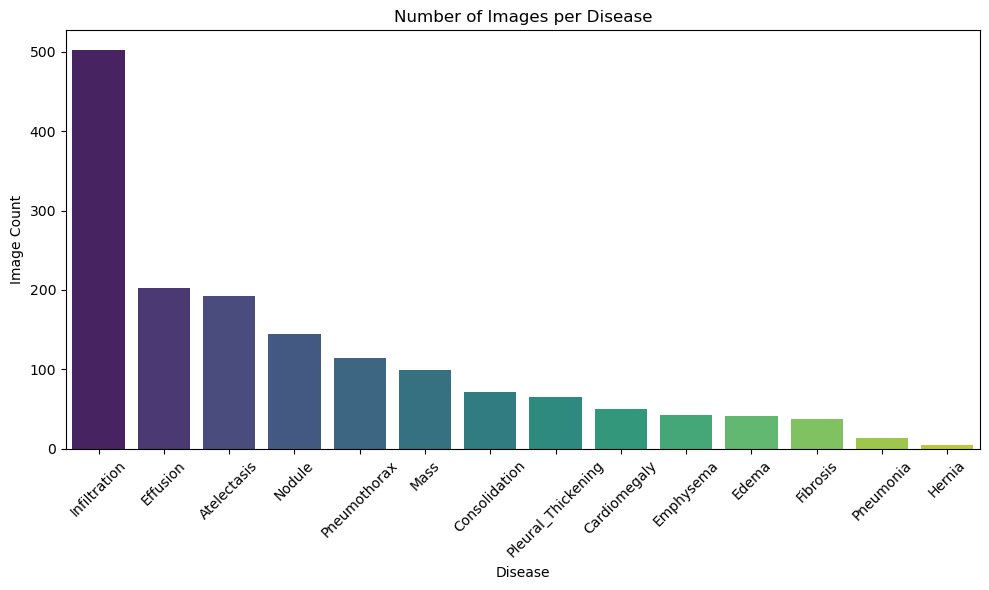

In [18]:
disease_columns = one_hot_labels.columns  # since these are your one-hot columns

# Calculate total count per disease
disease_counts = chest_disease_data[disease_columns].sum().sort_values(ascending=False)

# Convert to DataFrame for seaborn
disease_df = disease_counts.reset_index()
disease_df.columns = ['Disease', 'Count']

# Vertical barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=disease_df, x='Disease', y='Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Number of Images per Disease')
plt.ylabel('Image Count')
plt.xlabel('Disease')
plt.tight_layout()
plt.show()


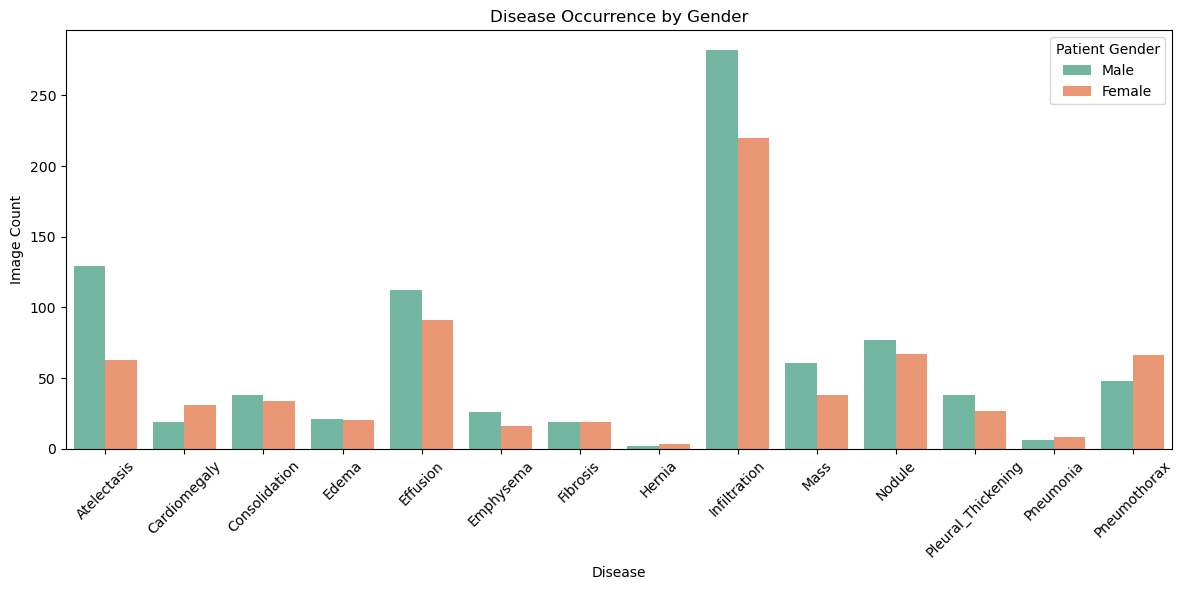

In [19]:
# Melt to long format: one row per (image, disease)
long_df = chest_disease_data.melt(
    id_vars=['Patient Gender'],
    value_vars=disease_columns,
    var_name='Disease',
    value_name='Present'
)

# Filter only rows where disease is present
long_df = long_df[long_df['Present'] == True]

# Barplot: Disease count by sex
plt.figure(figsize=(12, 6))
sns.countplot(data=long_df, x='Disease', hue='Patient Gender', palette='Set2')
plt.title('Disease Occurrence by Gender')
plt.xlabel('Disease')
plt.ylabel('Image Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

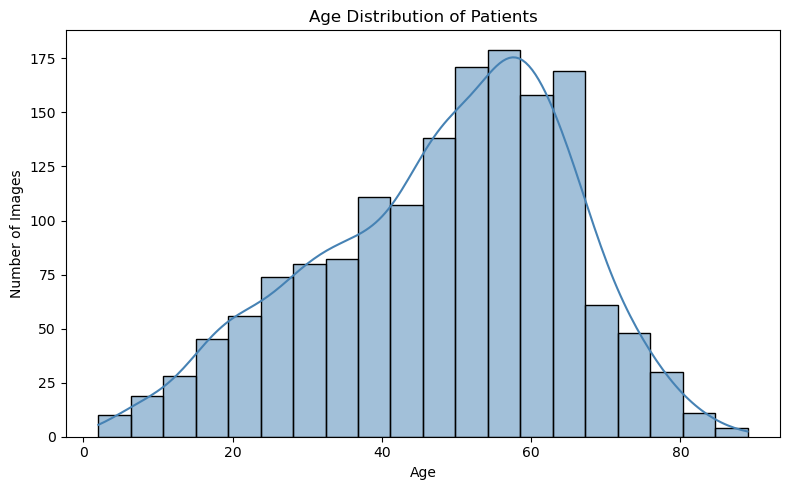

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(data=chest_disease_data, x='Patient Age', kde=True, bins=20, color='steelblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

C:\Users\jlai2\AppData\Local\Temp\ipykernel_27028\2851757564.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=long_age_df, x='Disease', y='Patient Age', palette='Set3')


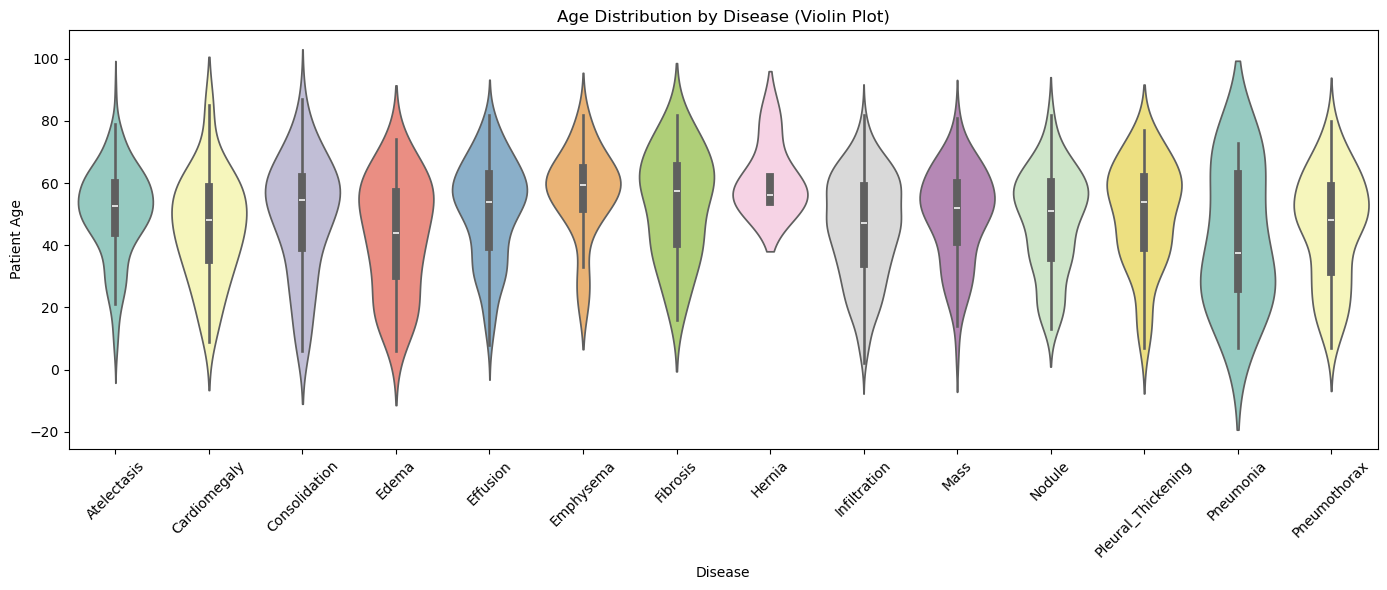

In [22]:
# Melt again for age-disease pairs
long_age_df = chest_disease_data.melt(
    id_vars=['Patient Age'],
    value_vars=disease_columns,
    var_name='Disease',
    value_name='Present'
)

# Filter for present diseases
long_age_df = long_age_df[long_age_df['Present'] == True]

# Plot violin plot
plt.figure(figsize=(14, 6))
sns.violinplot(data=long_age_df, x='Disease', y='Patient Age', palette='Set3')
plt.title('Age Distribution by Disease (Violin Plot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

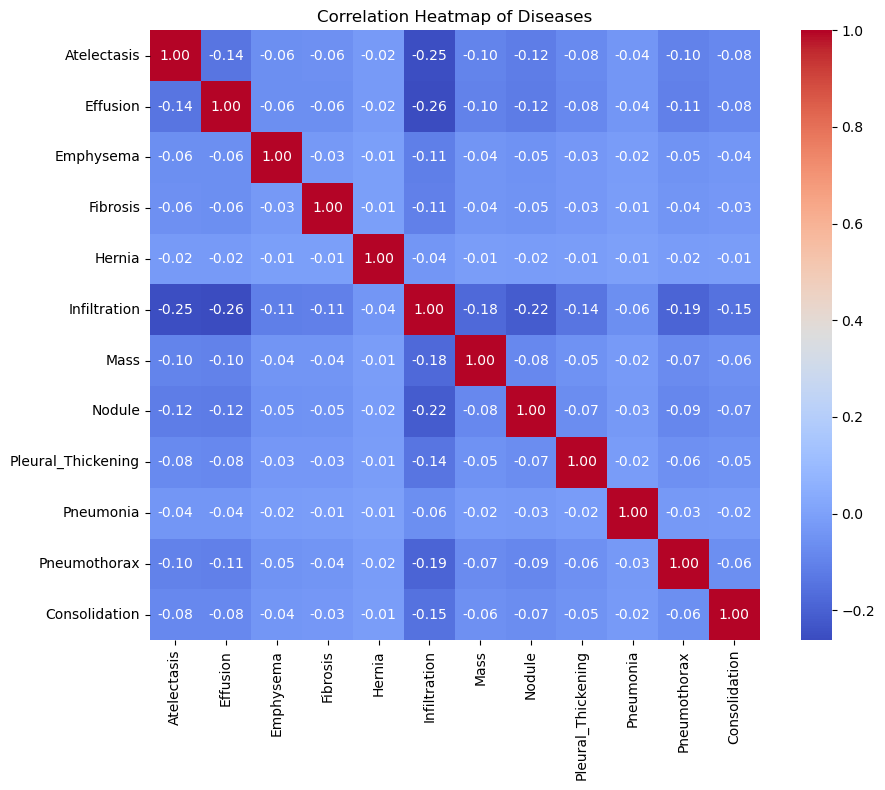

In [24]:
# Define your disease columns
disease_columns = ['Atelectasis', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
                   'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
                   'Pneumonia', 'Pneumothorax', 'Consolidation']

# Calculate correlation matrix (will be symmetric)
corr_matrix = chest_disease_data[disease_columns].astype(int).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Diseases')
plt.tight_layout()
plt.show()


## Model Selection

In [25]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.labels = dataframe[disease_columns].values.astype(float)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['Image Index'])  # e.g., data/images/00000061_002.png
        image = Image.open(img_path).convert("L")  # Load as grayscale

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return image, label


In [26]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (expected by DenseNet)
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel RGB-like format
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  # Convert image to PyTorch tensor and scale [0-1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Match ImageNet's expected input
                         std=[0.229, 0.224, 0.225])
])


In [27]:
train_dataset = ChestXrayDataset(chest_disease_data, image_dir='images', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [28]:
model = models.densenet121(pretrained=True)

# Replace final classification layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, len(disease_columns)),  # one output per disease
    nn.Sigmoid()  # for multi-label (not softmax)
)


c:\Users\jlai2\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jlai2\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [30]:
for epoch in range(5):  # change as needed
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.4152
Epoch 2, Loss: 0.2336
Epoch 3, Loss: 0.1973
Epoch 4, Loss: 0.1672
Epoch 5, Loss: 0.1394


In [39]:
model.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for images, labels in train_loader:  # or test_loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = outputs.cpu()
        preds = (probs >= 0.15).float()  # Threshold at 0.5

        all_preds.append(preds)
        all_probs.append(probs)
        all_targets.append(labels.cpu())


y_true = torch.cat(all_targets).numpy()
y_pred = torch.cat(all_preds).numpy()
y_prob = torch.cat(all_probs).numpy()

# For F1, Precision, Recall per class:
print(classification_report(y_true, y_pred, target_names=disease_columns, zero_division=0))

try:
    auc = roc_auc_score(y_true, y_prob, average='macro')
    print(f"AUC (macro-average): {auc:.4f}")
except ValueError:
    print("AUC could not be computed (some classes missing positive examples).")

                    precision    recall  f1-score   support

       Atelectasis       0.63      0.95      0.76       192
          Effusion       0.77      0.96      0.86       203
         Emphysema       0.95      0.43      0.59        42
          Fibrosis       1.00      0.16      0.27        38
            Hernia       0.00      0.00      0.00         5
      Infiltration       0.57      1.00      0.72       502
              Mass       0.71      0.83      0.77        99
            Nodule       0.58      0.92      0.71       144
Pleural_Thickening       1.00      0.37      0.54        65
         Pneumonia       0.00      0.00      0.00        14
      Pneumothorax       0.57      0.93      0.71       114
     Consolidation       0.74      0.68      0.71        72

         micro avg       0.63      0.87      0.73      1490
         macro avg       0.63      0.60      0.55      1490
      weighted avg       0.66      0.87      0.71      1490
       samples avg       0.69      0.8

In [40]:
exact_match_accuracy = (y_true == y_pred).all(axis=1).mean()
print(f"Exact Match Accuracy: {exact_match_accuracy * 100:.2f}%")

false_negatives = ((y_true == 1) & (y_pred == 0)).sum(axis=0)
total_positives = (y_true == 1).sum(axis=0)
percent_false_negatives = false_negatives / total_positives * 100

for i, disease in enumerate(disease_columns):
    print(f"{disease}: {false_negatives[i]} FNs ({percent_false_negatives[i]:.2f}% missed)")

total_fn = false_negatives.sum()
total_tp_fn = total_positives.sum()
overall_fn_rate = total_fn / total_tp_fn * 100

print(f"\nOverall False Negative Rate: {overall_fn_rate:.2f}%")


Exact Match Accuracy: 57.69%
Atelectasis: 9 FNs (4.69% missed)
Effusion: 8 FNs (3.94% missed)
Emphysema: 24 FNs (57.14% missed)
Fibrosis: 32 FNs (84.21% missed)
Hernia: 5 FNs (100.00% missed)
Infiltration: 0 FNs (0.00% missed)
Mass: 17 FNs (17.17% missed)
Nodule: 12 FNs (8.33% missed)
Pleural_Thickening: 41 FNs (63.08% missed)
Pneumonia: 14 FNs (100.00% missed)
Pneumothorax: 8 FNs (7.02% missed)
Consolidation: 23 FNs (31.94% missed)

Overall False Negative Rate: 12.95%


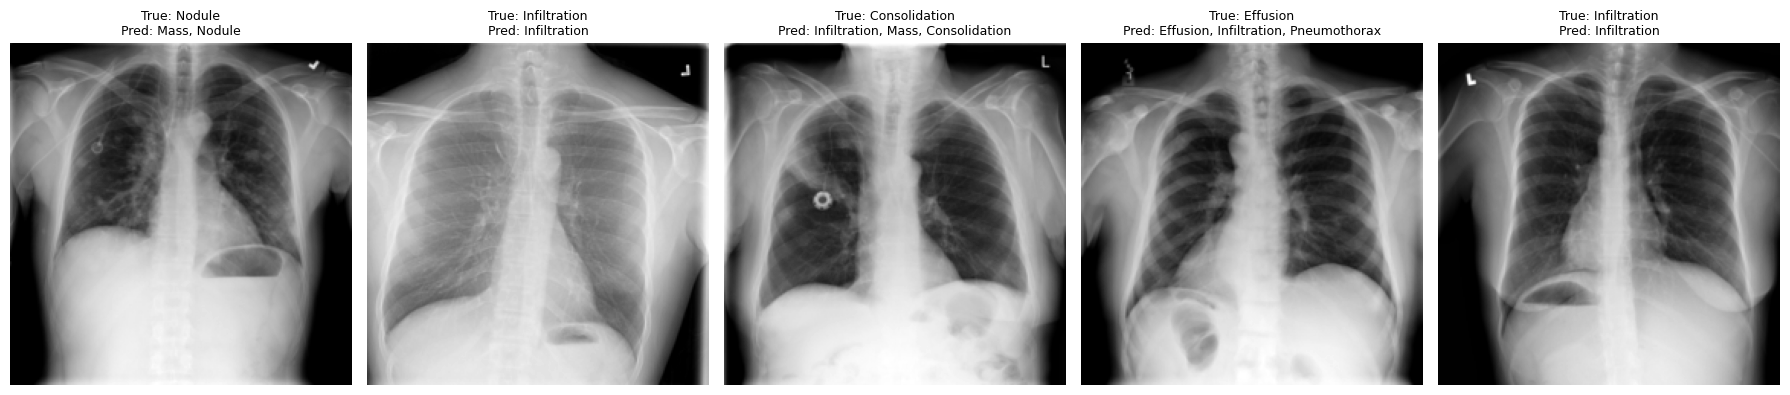

In [ ]:
# Inference mode
model.eval()
images, true_labels = next(iter(train_loader))  # or val_loader if available
images = images.to(device)
outputs = model(images).cpu().detach()
predicted_labels = (outputs >= 0.15).float()

# Helper to map label vector back to disease names
def get_label_names(label_vector):
    return [disease_columns[i] for i, val in enumerate(label_vector) if val == 1]

# Show 5 examples
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(18, 4))

for i in range(num_examples):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # un-normalize
    img = np.clip(img, 0, 1)

    axes[i].imshow(img[..., 0], cmap='gray')  # single channel view
    axes[i].axis('off')

    true_names = get_label_names(true_labels[i])
    pred_names = get_label_names(predicted_labels[i])

    axes[i].set_title(f"True: {', '.join(true_names)}\nPred: {', '.join(pred_names)}", fontsize=9)

plt.tight_layout()
plt.show()
